In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from models import get_discriminator_model,get_snapshot_generator_model, WGAN, GANMonitor
from input_data import WishartCSM
from acoular import MicGeom, SteeringVector, ImportGrid


ntraining_samples = 10000
IMG_SHAPE = (64, 64, 2)
BATCH_SIZE = 512
noise_dim = 128
epochs = 20
f = 343*16

# create the training data
wcsm = WishartCSM(
    mics=MicGeom( from_file="tub_vogel64_ap1.xml"),
    loc=(0,0,0.5),
    f=f,
    scale=np.eye(1),
    df=1000,
)
csm = np.array([wcsm.sample_csm() for n in range(ntraining_samples)])
csm_real_imag = np.concatenate([np.real(csm)[...,np.newaxis],np.imag(csm)[...,np.newaxis]],axis=3)

d_model = get_discriminator_model(input_shape=IMG_SHAPE)
d_model.summary()

g_model = get_snapshot_generator_model(noise_dim=noise_dim)
g_model.summary()

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    n_critic=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 2)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 68, 68, 2)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 34, 34, 64)        3264      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 128)     

In [3]:

# Start training
wgan.fit(
    csm_real_imag, 
    batch_size=BATCH_SIZE, 
    epochs=epochs, 
    #callbacks=[GANMonitor(num_img=3, latent_dim=noise_dim)]
    )


Epoch 1/20
20/20 [==============================] - 22s 646ms/step - d_loss: -376.8996 - g_loss: 805.9109
Epoch 2/20
20/20 [==============================] - 12s 613ms/step - d_loss: -104.9275 - g_loss: 94.3048
Epoch 3/20
20/20 [==============================] - 12s 607ms/step - d_loss: -117.6949 - g_loss: 59.5625
Epoch 4/20
20/20 [==============================] - 12s 598ms/step - d_loss: -125.1049 - g_loss: 126.0146
Epoch 5/20
20/20 [==============================] - 12s 599ms/step - d_loss: -90.4944 - g_loss: 166.3660
Epoch 6/20
20/20 [==============================] - 12s 600ms/step - d_loss: -48.4256 - g_loss: 155.9432
Epoch 7/20
20/20 [==============================] - 12s 602ms/step - d_loss: -24.4508 - g_loss: 132.6191
Epoch 8/20
20/20 [==============================] - 12s 610ms/step - d_loss: -16.6242 - g_loss: 123.3344
Epoch 9/20
20/20 [==============================] - 12s 612ms/step - d_loss: -13.4430 - g_loss: 118.0551
Epoch 10/20
20/20 [==============================] - 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


Text(0.5, 1.0, 'sampled csm eigspec')

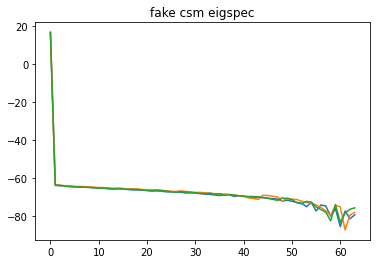

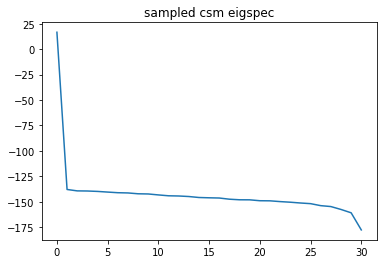

In [4]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(3, noise_dim))
generated_snapshots = g_model(random_latent_vectors)

csm_real_part = tf.reduce_sum(tf.einsum('bijm,bklm->bilm',generated_snapshots,tf.transpose(generated_snapshots,[0,2,1,3])),axis=-1) 
csm_imag_part = tf.einsum('bij,bkl->bil',generated_snapshots[:,:,:,1],tf.transpose(generated_snapshots[:,:,:,0],[0,2,1])) - tf.einsum('bij,bkl->bil',generated_snapshots[:,:,:,0],tf.transpose(generated_snapshots[:,:,:,1],[0,2,1]))
generated_csm = tf.concat([tf.expand_dims(csm_real_part,axis=-1),tf.expand_dims(csm_imag_part,axis=-1)],axis=3)                
generated_csm = generated_csm / 64 # divide by the number of snapshots             


plt.figure()
plt.title("fake csm eigspec")
generated_csm = generated_csm.numpy()[:,:,:,0] + 1j*generated_csm.numpy()[:,:,:,1]
eig = np.linalg.eigvals(generated_csm)
plt.plot(10*np.log10(eig.T))

plt.figure()
wcsm.df = 64
csm = wcsm.sample_csm()
eig, vec = np.linalg.eigh(csm)
plt.plot(10*np.log10(np.real(eig)[::-1]))
plt.title("sampled csm eigspec")
#plt.plot(10*np.log10(eig.T))


Text(0.5, 1.0, 'sampled csm eigspec')

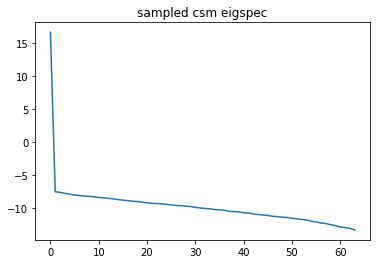

In [13]:
#### example how to add some independent noise to the csm 

independent_noise_csm = WishartCSM(
    mics=MicGeom( from_file="tub_vogel64_ap1.xml"),
    loc=(0,0,0.5),
    f=f,
    scale=np.eye(64)*.1,
    df=1000,
)

noise_csm = independent_noise_csm.sample_complex_wishart()/independent_noise_csm.df
full_csm = csm + noise_csm # add noise

# plot eigspec
eig, vec = np.linalg.eigh(full_csm)
plt.plot(10*np.log10(np.real(eig)[::-1]))
plt.title("sampled csm eigspec")


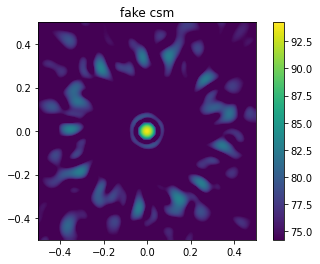

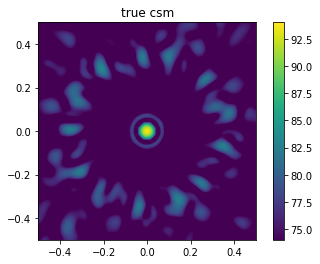

In [4]:
#### perform beamforming with the sampled version

from spectra import PowerSpectraImport
from acoular import RectGrid, BeamformerBase, L_p

# generate test data, in real life this would come from an array measurement
ps_import = PowerSpectraImport(csm=generated_csm[0][np.newaxis,:,:], frequencies=f)
rg = RectGrid( x_min=-0.5, x_max=0.5, y_min=-0.5, y_max=0.5, z=0.5, \
increment=0.01 )
st = SteeringVector(grid=rg, mics=MicGeom( from_file="tub_vogel64_ap1.xml"))
bb = BeamformerBase( freq_data=ps_import, steer=st, r_diag=False, cached=False )
pm = bb.synthetic( f, 0 )
Lm = L_p( pm )

# show map
plt.figure()
plt.title("fake csm")
plt.imshow( Lm.T, origin='lower', vmin=Lm.max()-20, extent=rg.extend(), \
interpolation='bicubic')
plt.colorbar()

#### perform beamforming with the true version

ps_import.csm = csm[np.newaxis,...]
pm = bb.synthetic( f, 0 )
Lm = L_p( pm )

# show map
plt.figure()
plt.title("true csm")
plt.imshow( Lm.T, origin='lower', vmin=Lm.max()-20, extent=rg.extend(), \
interpolation='bicubic')
plt.colorbar()

# Now let's try it with random positions (similar to Gerstoft: Second Example)

In [5]:
# create the data ( this may take a while!)
nloc = 4
locs = [(np.random.uniform(-.5,.5),np.random.uniform(-.5,.5)) for n in range(nloc)]

csm_data = []
for i in range(nloc):   
    # create the training data
    x,y = locs[i]
    wcsm = WishartCSM(
        mics=MicGeom( from_file="tub_vogel64_ap1.xml"),
        loc=(x,y,0.5),
        f=f,
        scale=np.eye(1),
        df=1000,
    )
    csm_data.append(wcsm.sample_csm())
csm_data = np.concatenate([np.real(csm_data)[...,np.newaxis],np.imag(csm_data)[...,np.newaxis]],axis=3)


In [10]:
ntraining_samples = 10000*nloc
training_data = np.array([csm_data[np.random.randint(0,nloc)].copy() for i in range(ntraining_samples)]) # repeat csm's

In [11]:
# Start training
wgan.fit(
    training_data, 
    batch_size=BATCH_SIZE, 
    epochs=15, 
    #callbacks=[GANMonitor(num_img=3, latent_dim=noise_dim)]
    )


Epoch 1/15
79/79 [==============================] - 49s 616ms/step - d_loss: -74.4023 - g_loss: 47.5737
Epoch 2/15
79/79 [==============================] - 48s 613ms/step - d_loss: -52.1135 - g_loss: 192.4433
Epoch 3/15
79/79 [==============================] - 49s 614ms/step - d_loss: -30.3935 - g_loss: 157.9514
Epoch 4/15
79/79 [==============================] - 49s 620ms/step - d_loss: -24.2246 - g_loss: 123.5807
Epoch 5/15
79/79 [==============================] - 49s 615ms/step - d_loss: -20.3637 - g_loss: 101.9653
Epoch 6/15
79/79 [==============================] - 49s 618ms/step - d_loss: -18.2478 - g_loss: 93.0829
Epoch 7/15
79/79 [==============================] - 49s 615ms/step - d_loss: -16.6032 - g_loss: 85.1853
Epoch 8/15
79/79 [==============================] - 49s 620ms/step - d_loss: -15.5635 - g_loss: 75.1517
Epoch 9/15
79/79 [==============================] - 49s 615ms/step - d_loss: -14.1710 - g_loss: 70.8074
Epoch 10/15
79/79 [==============================] - 49s 616

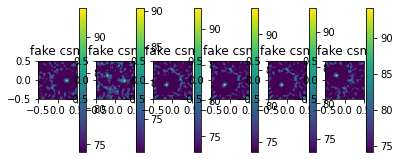

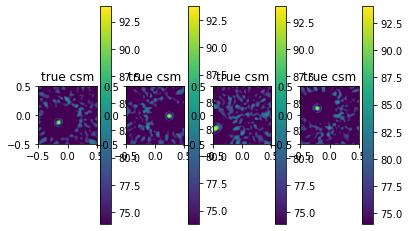

In [16]:
#### perform beamforming with the sampled version
n_examples = 6


random_latent_vectors = tf.random.normal(shape=(n_examples, noise_dim))
generated_snapshots = g_model(random_latent_vectors)

csm_real_part = tf.reduce_sum(tf.einsum('bijm,bklm->bilm',generated_snapshots,tf.transpose(generated_snapshots,[0,2,1,3])),axis=-1) 
csm_imag_part = tf.einsum('bij,bkl->bil',generated_snapshots[:,:,:,1],tf.transpose(generated_snapshots[:,:,:,0],[0,2,1])) - tf.einsum('bij,bkl->bil',generated_snapshots[:,:,:,0],tf.transpose(generated_snapshots[:,:,:,1],[0,2,1]))
generated_csm = tf.concat([tf.expand_dims(csm_real_part,axis=-1),tf.expand_dims(csm_imag_part,axis=-1)],axis=3)                
generated_csm = generated_csm / 64 # divide by the number of snapshots             
generated_csm = generated_csm.numpy()[:,:,:,0] + 1j*generated_csm.numpy()[:,:,:,1]

plt.figure()
for i in range(n_examples):
    plt.subplot(1,n_examples,i+1)
    # import csm and perform beamforming
    ps_import.csm = generated_csm[i][np.newaxis,...]
    pm = bb.synthetic( f, 0 )
    Lm = L_p( pm )

    # show map
    plt.title("fake csm")
    plt.imshow( Lm.T, origin='lower', vmin=Lm.max()-20, extent=rg.extend(), \
    interpolation='bicubic')
    plt.colorbar()
    
    
plt.figure()
for i in range(nloc):
    csm = csm_data[:nloc,:,:,0] + 1j*csm_data[:nloc,:,:,1]
    plt.subplot(1,nloc,i+1)
    # import csm and perform beamforming
    ps_import.csm = csm[i][np.newaxis,...]
    pm = bb.synthetic( f, 0 )
    Lm = L_p( pm )

    # show map
    plt.title("true csm")
    plt.imshow( Lm.T, origin='lower', vmin=Lm.max()-20, extent=rg.extend(), \
    interpolation='bicubic')
    plt.colorbar()    